# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange # https://tqdm.github.io/

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
im = cv2.imread('Data/Student101.jpeg')
show_img(im, -1, figsize=(16,16))

NameError: name 'show_img' is not defined

In [4]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gradX = cv2.Scharr(gray, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
gradY = cv2.Scharr(gray, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges
show_img(gradY)

NameError: name 'show_img' is not defined

In [5]:
def show_img(im, ax=None, figsize=(8,8)):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax

In [6]:
gradY.min(), gradY.max()

(-2072.0, 2288.0)

In [7]:
gradYs = (gradY - gradY.min()) / (gradY.max() - gradY.min())
gradYs.min(), gradYs.max()

(0.0, 1.0)

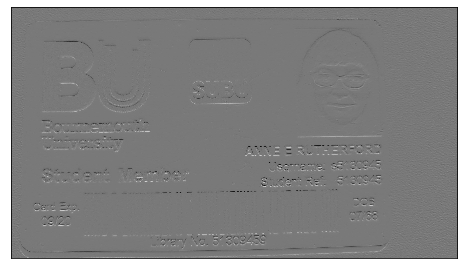

In [8]:
show_img(gradYs)

We now combine the two gradients by subtructing one of them from the other. The rationale is that this should emphasize the vertical edges (i.e. high horizontal gradients).

We will now calculate the `Scharr` dervitaive of the image, both horizontal and vertical. The derivative is the rate of change and in images it is calculated at any pixel position by subtracting the intensities of the neighbouring pixels: left and right for `x` dervative, bottom and top for `y` derivative. More details can be found [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html).

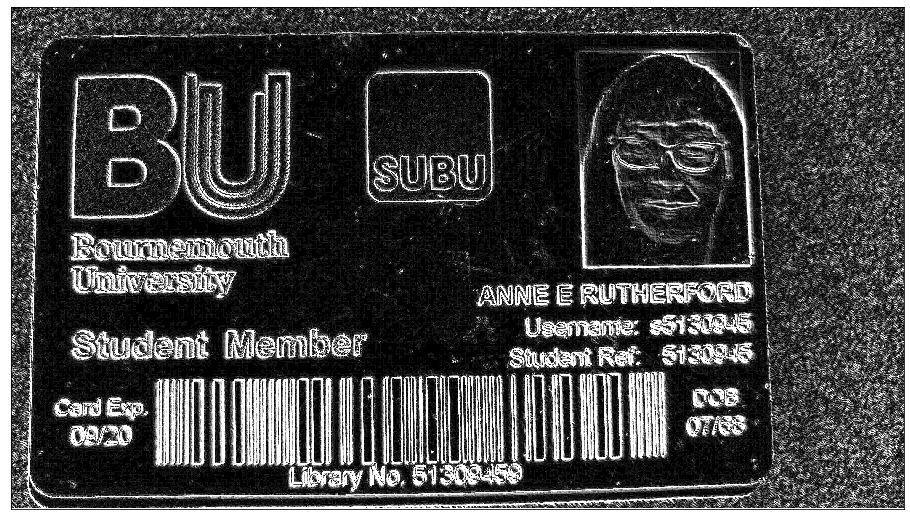

In [9]:
grad = cv2.convertScaleAbs(gradY-gradX) # normalisation just like we did on our own previously
show_img(grad, figsize=(16,16));

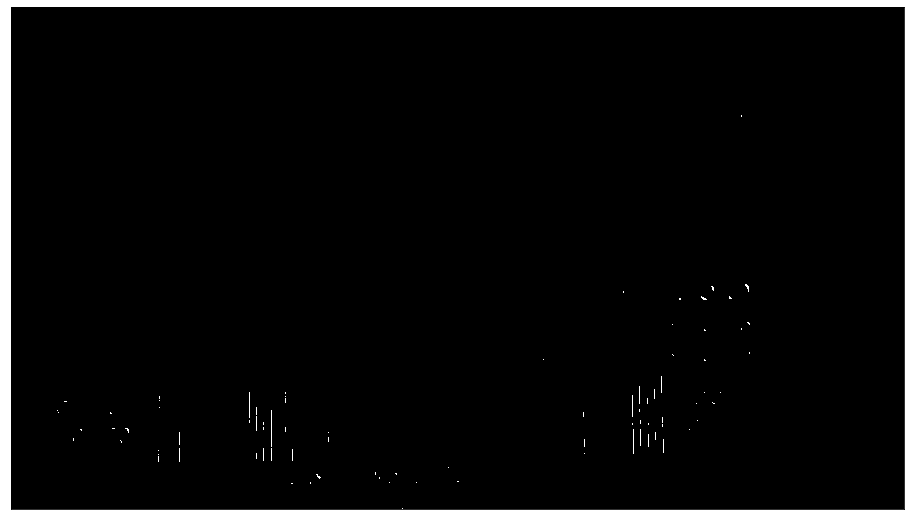

In [10]:
blur = cv2.blur(grad, (17, 17))
_,thr = cv2.threshold(blur, 225, 255, cv2.THRESH_BINARY)
show_img(thr, figsize=(16,16));

What if we simply used erosion and dilation? We want to erode first to get rid the "noise" and then dilate to get a connected region where the barcode is.

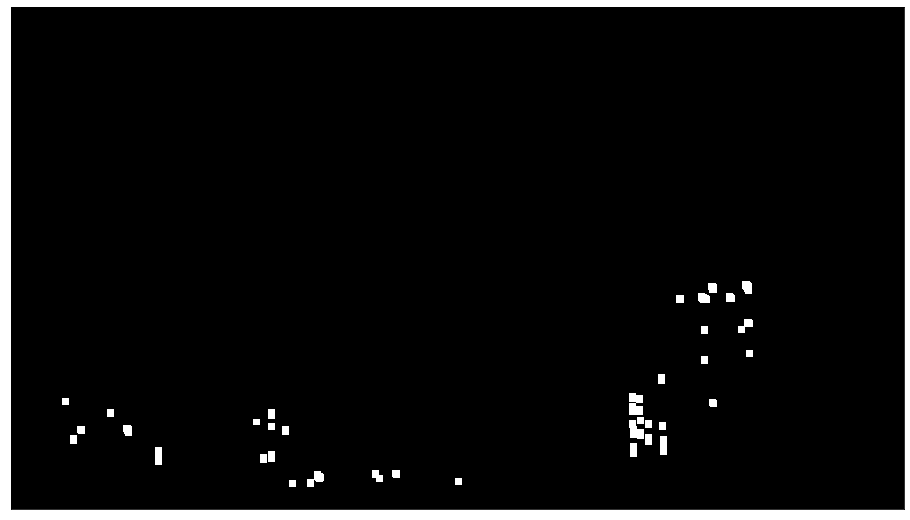

In [11]:
morph = cv2.erode(thr, None, iterations=1)
morph = cv2.dilate(morph, None, iterations=10)
show_img(morph, figsize=(16,16));

That didn't work because we have applied both operations globally to the whole image. What if we could do it on a region by region basis? The approach we're going to use is outlined [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#closing). We will use a rectangle (wide and short) as our [structuring element](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#structuring-element) as we want to marge vertical lines.

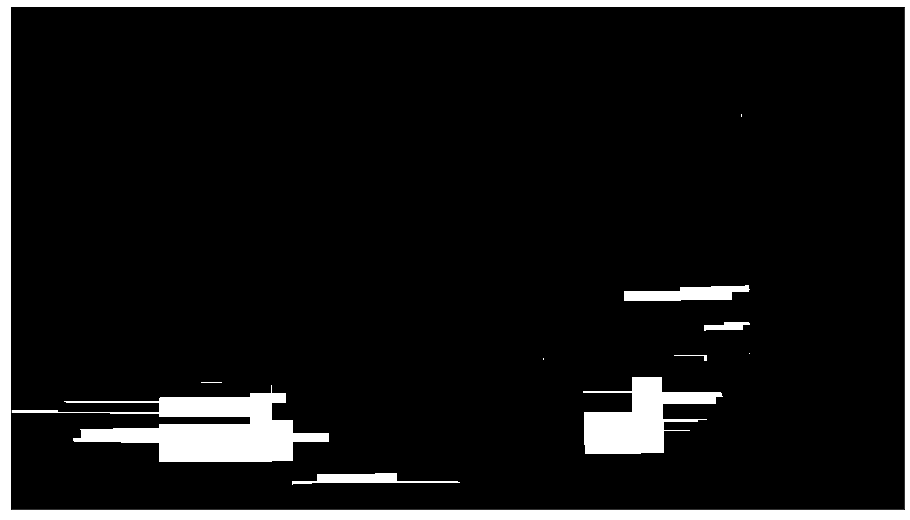

In [12]:
morph = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (300, 22)))
show_img(morph, figsize=(16,16));

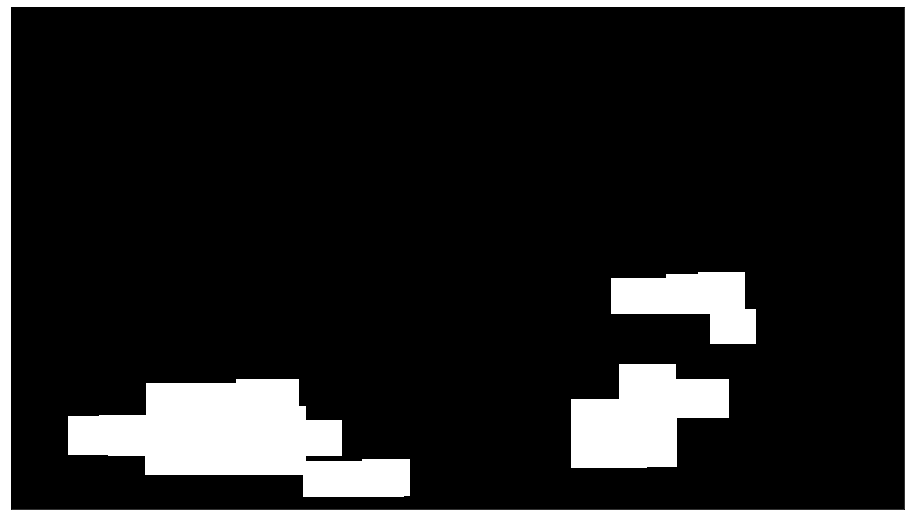

In [13]:
morph_e = cv2.erode(morph, None, iterations=10)
morph_d = cv2.dilate(morph_e, None, iterations=50)
show_img(morph_d, figsize=(16,16));

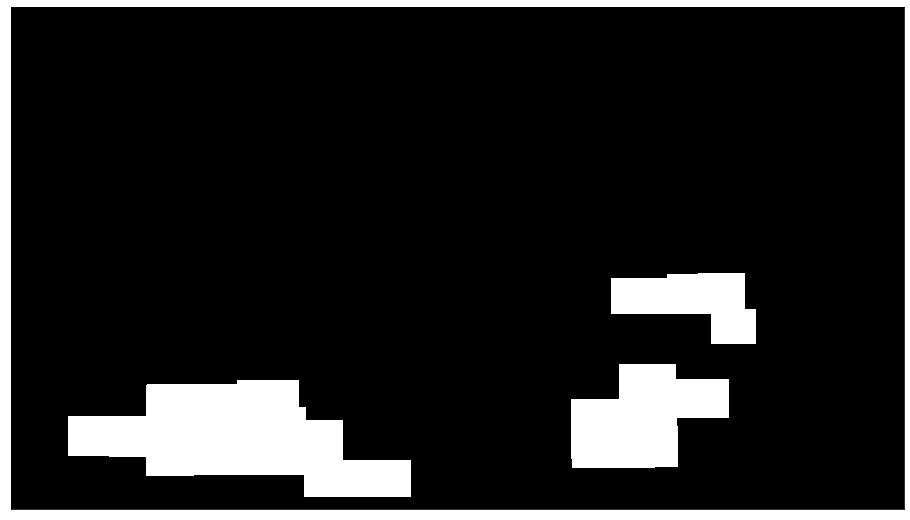

In [14]:
morph2 = cv2.morphologyEx(morph_d, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (300,22)))
show_img(morph2, figsize=(16,16));

In [15]:
np.unique(morph2)

array([  0, 255], dtype=uint8)

In [16]:
ixs = np.argwhere(morph2>0) # we will look at a moe robust approach next time
ixs[:10]

array([[ 802, 2068],
       [ 802, 2069],
       [ 802, 2070],
       [ 802, 2071],
       [ 802, 2072],
       [ 802, 2073],
       [ 802, 2074],
       [ 802, 2075],
       [ 802, 2076],
       [ 802, 2077]], dtype=int64)

In [17]:
bbox = ixs[:,0].min(), ixs[:,1].min(), ixs[:,0].max(), ixs[:,1].max()
bbox

(802, 172, 1475, 2242)

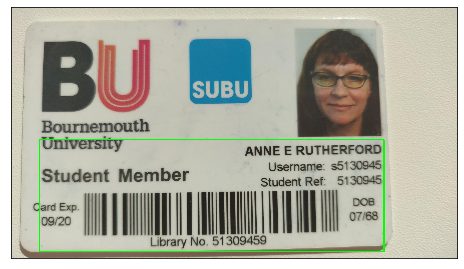

In [18]:
fin = cv2.rectangle(im.copy(), bbox[:2][::-1], bbox[2:][::-1], (0, 255, 0), 5)
show_img(fin, figsize=(8,8));